# Forecasting Monthly Average Reatil Price of Steak in Canada

#### Loading Libraries

In [59]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
from pandas.tseries.offsets import MonthEnd
# Data Visualization
import matplotlib.pyplot as plt

# Time Series Forecasting
from prophet import Prophet
# Metrics
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
# Plots
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly, plot_weekly
from prophet.plot import add_changepoints_to_plot

# Warnings
import warnings

# TQDM Notebook
from tqdm.notebook import tqdm

# Itertools
from itertools import product
from typing import Union

# Machine Learning Metrics
from sklearn.metrics import mean_absolute_error

# Statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [14]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [15]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

#### Loading Data

In [20]:
df = pd.read_csv('/Users/isisromero/desktop/time_series/data/monthly_avg_retail_price_food_canada.csv')

df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


#### Data Processing

In [21]:
df.shape

(16166, 15)

In [22]:
# Setting Steak's (1 Kg) Target Variable 
df = df[df['Products'] == 'Round steak, 1 kilogram']
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [23]:
# Getting Column Names
df.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

In [24]:
# Group & Dropping them off
cols_to_drop = ['GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS']

df = df.drop(cols_to_drop, axis=1)
df.head()

,REF_DATE,VALUE
0,1995-01,10.17
1,1995-02,10.29
2,1995-03,10.12
3,1995-04,10.38
4,1995-05,10.00


In [25]:
df.shape

(323, 2)

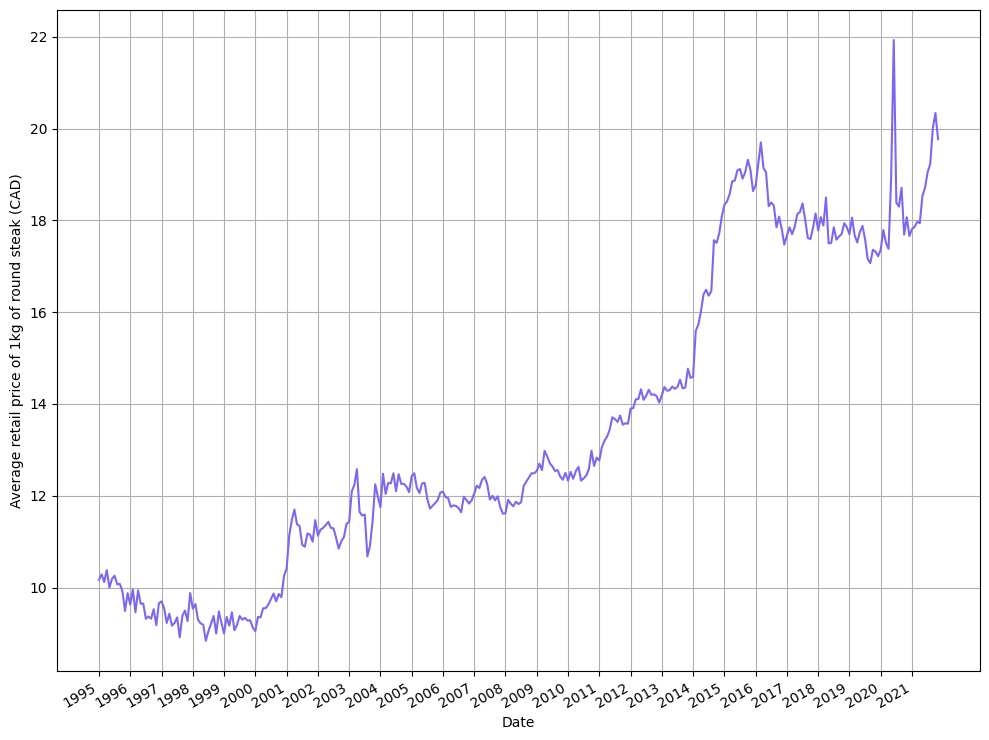

In [10]:
fig, ax = plt.subplots()

ax.plot(df['VALUE'], color='mediumslateblue')
ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()

##### Observation

As the first judgemental approach, there is an increasing trend over time. Nevertheless, there is no observable seasonality, making the Prophet not the best tool to apply, at least as the first procedure.

#### Modeling Prophet

In [27]:
# Renaming Columns
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1995-01,10.17
1,1995-02,10.29
2,1995-03,10.12
3,1995-04,10.38
4,1995-05,10.00


In [28]:
# Formatting Date Procedure
df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)

df.head()

,ds,y
0,1995-01-31,10.17
1,1995-02-28,10.29
2,1995-03-31,10.12
3,1995-04-30,10.38
4,1995-05-31,10.00


#### Train & Test Split

In [29]:
# Train set
train = df[:-36]
# Test set
test = df[-36:]

train.tail()

,ds,y
282,2018-07-31,17.85
283,2018-08-31,17.58
284,2018-09-30,17.65
285,2018-10-31,17.70
286,2018-11-30,17.94


#### Hyperparameter Tuning

*Observation*: Since Holidays don't look like they affect steak prices, holiday effects won't be included.

In [33]:
# # Parameters Grid
# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.1, 1.0],
#     'seasonality_prior_scale': [0.1, 1.0, 10.0]
# }

# # Unique Combination List
# params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# # Metric Criterion for Large Errors
# mses = []

# # Initial Training Set
# cutoffs = pd.date_range(start='2000-01-31', end='2018-11-30', freq='36M')

# for param in params:
#     m = Prophet(**param)
#     m.fit(train)
    
#     df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     mses.append(df_p['mse'].values[0])
    
# tuning_results = pd.DataFrame(params)
# tuning_results['mse'] = mses

In [36]:
# Parameters Grid Adjustment
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

# Unique Possible Combination List
params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Preparar para la validación cruzada
mses = []

last_train_date = train['ds'].max()
cutoffs_end_date = last_train_date - pd.Timedelta(days=365)  
cutoffs = pd.date_range(start='2000-01-31', end=cutoffs_end_date, freq='36M')

# Cross Validation Execution
for param in params:
    m = Prophet(**param)
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
# Stoaging outcomes on DataFrame 
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

# MSE best Hyperparamters
best_params_index = np.argmin(mses)
best_params = params[best_params_index]

print(f"Best Parameters: {best_params}")

10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing
10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:09 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing
10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:11 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:12 - cmdstanpy - INFO - Chain [1] start processing
10:42:12 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:13 - cmdstanpy - INFO - Chain [1] done processing
10:42:13 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0}


In [37]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0}


In [38]:
best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0}

#### Prophet Model using Best Params

In [39]:
m = Prophet(**best_params)
m.fit(train);

10:44:05 - cmdstanpy - INFO - Chain [1] start processing
10:44:05 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Setting Future's DataFrame
future = m.make_future_dataframe(periods=36, freq='M')

In [42]:
# Generating Predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
311,2020-12-31,19.206481,17.730891,20.779456
312,2021-01-31,19.202261,17.666420,20.863791
313,2021-02-28,19.536531,17.825409,21.326328
314,2021-03-31,19.460173,17.670931,21.359943
315,2021-04-30,19.584838,17.650544,21.625324
316,2021-05-31,19.529604,17.548355,21.695993
317,2021-06-30,19.457723,17.465361,21.679447
318,2021-07-31,19.420976,17.265940,21.736645
319,2021-08-31,19.407453,17.077395,21.751173
320,2021-09-30,19.416532,16.976938,21.901137


In [43]:
# Appending on Test set
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
287,2018-12-31,17.85,18.593598,17.861100,19.256326
288,2019-01-31,17.70,18.579615,17.906049,19.235284
289,2019-02-28,18.06,18.759317,18.089003,19.426628
290,2019-03-31,17.67,18.786714,18.120537,19.489098
291,2019-04-30,17.52,19.040093,18.354206,19.742536


In [44]:
# Appending Baseline Benchmark on Test set
test['Baseline'] = train['y'].iloc[-1]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,Baseline
287,2018-12-31,17.85,18.593598,17.861100,19.256326,17.94
288,2019-01-31,17.70,18.579615,17.906049,19.235284,17.94
289,2019-02-28,18.06,18.759317,18.089003,19.426628,17.94
290,2019-03-31,17.67,18.786714,18.120537,19.489098,17.94
291,2019-04-30,17.52,19.040093,18.354206,19.742536,17.94


#### Model Evaluation Performance

In [46]:
baseline_mae = mean_absolute_error(test['y'], test['Baseline'])
prophet_mae = mean_absolute_error(test['y'], test['yhat'])

print(prophet_mae)
print(baseline_mae)

1.1661184436286733
0.6816666666666671


##### Model Performance Visualization

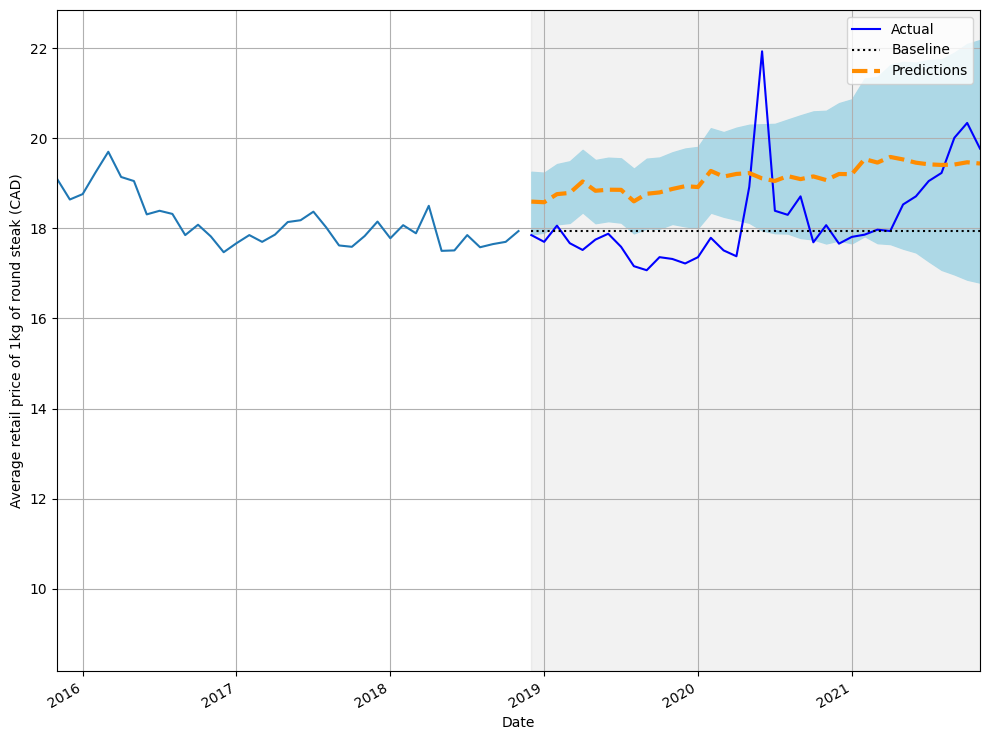

In [47]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

Observation: Prophet Model tends to overshoot the observed values. Since its outcome was (1.1661184436286733), this model
performs way worse than the baseline. 

##### Getting Model Components

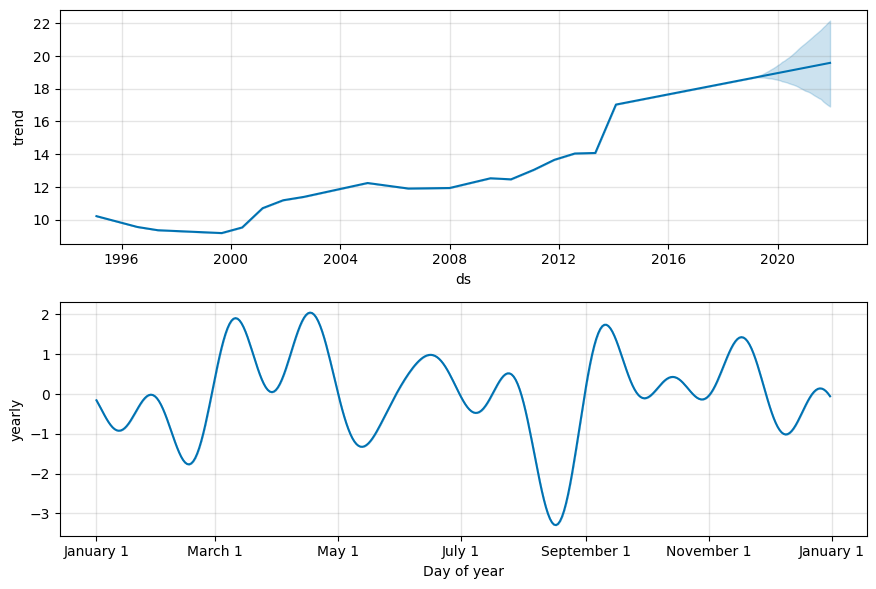

In [48]:
prophet_components_fig = m.plot_components(forecast)

#### Sarima Model Approach

##### Setting Dickey-Fuller

In [50]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.31276604677391096
p-value: 0.9779226633224506


##### 1st Differencing

In [51]:
y_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.784744900608818
p-value: 1.2558701587332173e-29


##### Setting SARIMAX Function

In [55]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [56]:
ps = range(1, 4, 1)
qs = range(1, 4, 1)
Ps = range(1, 4, 1)
Qs = range(1, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 12

##### Running Sarimax function out

In [57]:
SARIMA_result_df = optimize_SARIMAX(train['y'], None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 1)",59.812933
1,"(3, 2, 1, 1)",60.637794
2,"(2, 3, 1, 2)",60.751902
3,"(2, 3, 2, 1)",60.903631
4,"(2, 3, 3, 1)",61.849397
...,...,...
76,"(3, 3, 3, 2)",77.970524
77,"(3, 3, 1, 1)",78.325552
78,"(3, 3, 1, 3)",78.352988
79,"(3, 3, 3, 3)",79.542498


##### SARIMAX model outcome

In [61]:
SARIMA_model = SARIMAX(train['y'], order=(2,1,3), seasonal_order=(1,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  287
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 -21.906
Date:                              Mon, 11 Mar 2024   AIC                             59.813
Time:                                      11:34:26   BIC                             89.061
Sample:                                           0   HQIC                            71.536
                                              - 287                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2611      0.057     22.192      0.000       1.150       1.372
ar.L2         -0.91

##### Checking Diagnose

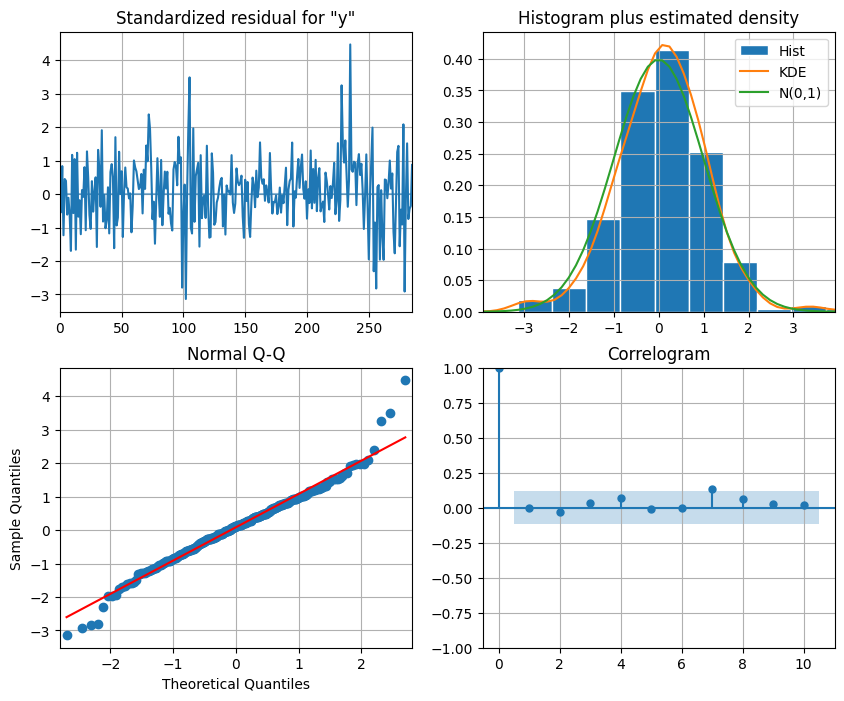

In [62]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

##### LJung-Box Test

In [63]:
# Running the Ljung-Box test on the residuals
residuals = SARIMA_model_fit.resid
results = acorr_ljungbox(residuals, lags=np.arange(1, 11, 1))

# Accessing the p-values from the results dictionary
pvalues = results['lb_pvalue']

print(pvalues)

1     0.908152
2     0.944558
3     0.968053
4     0.985896
5     0.996134
6     0.998977
7     0.999759
8     0.999943
9     0.999982
10    0.999916
Name: lb_pvalue, dtype: float64


#### Generating SARIMAX Predictions

In [64]:
SARIMA_pred = SARIMA_model_fit.get_prediction(287, 322).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

##### SARIMAX MAE 

In [65]:
SARIMA_mae = mean_absolute_error(test['y'], test['SARIMA_pred'])

print(SARIMA_mae)

0.6632491925004435


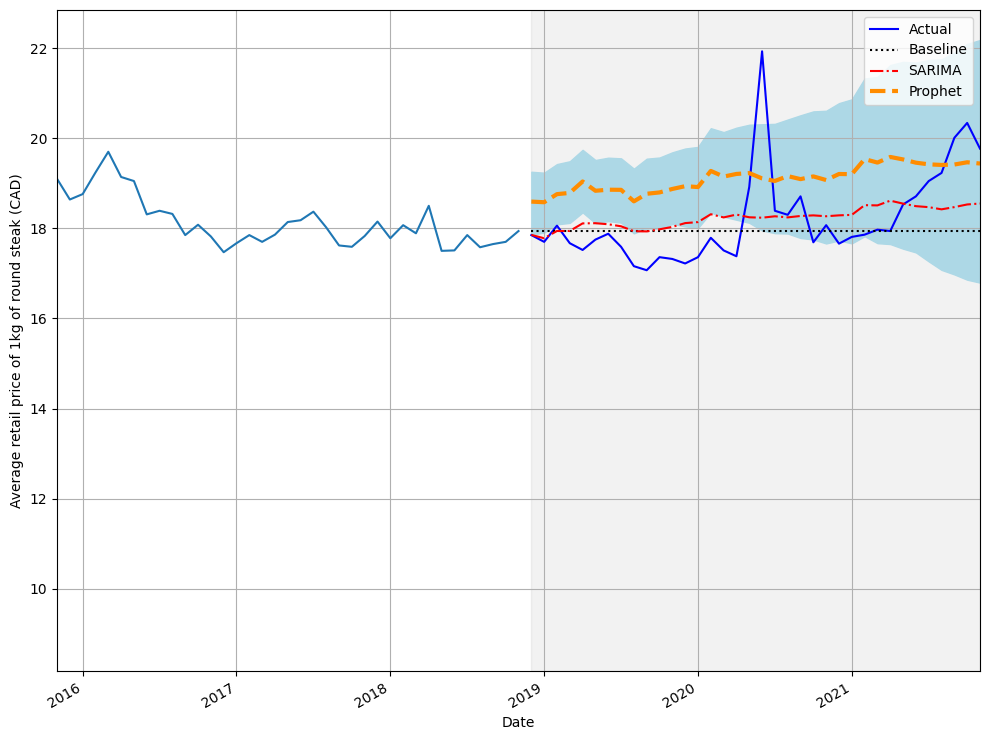

In [66]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['SARIMA_pred'], 'r-.', label='SARIMA')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Prophet')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()